# Filters and Denoising Introduction


This tutorial demonstrates convolution using the *scikit-image* library. The tutorial covers:
* Convolution/correlation with manual and predefined filters.
* Explicitly construct filters to perform specific operations.

As a first step, it is necessary to import the libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from skimage import data, filters
from scipy import signal
import scipy
import scipy.ndimage as sp
import seaborn as sns
import pandas as pd
from skimage import data, color
from scipy.signal import convolve2d

Scikit-Image has a set of example images (see the [documentation](https://scikit-image.org/docs/stable/api/skimage.data.html) for a complete list). The cell below prints the name of all images and displays the rocket image:

['astronaut', 'binary_blobs', 'brain', 'brick', 'camera', 'cat', 'cell', 'cells3d', 'checkerboard', 'chelsea', 'clock', 'coffee', 'coins', 'colorwheel', 'create_image_fetcher', 'data_dir', 'download_all', 'eagle', 'file_hash', 'grass', 'gravel', 'horse', 'hubble_deep_field', 'human_mitosis', 'image_fetcher', 'immunohistochemistry', 'kidney', 'lbp_frontal_face_cascade_filename', 'lfw_subset', 'lily', 'logo', 'microaneurysms', 'moon', 'nickel_solidification', 'page', 'protein_transport', 'retina', 'rocket', 'shepp_logan_phantom', 'skin', 'stereo_motorcycle', 'text', 'vortex']


(-0.5, 639.5, 426.5, -0.5)

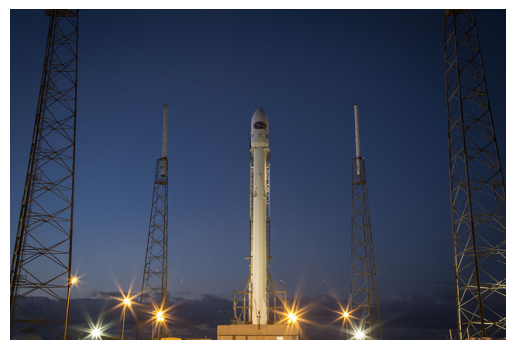

In [2]:
print(data.__all__)
plt.imshow(data.rocket(), cmap="gray")
plt.axis(False)

Linear filters are implemented as inner products and have many applications, such as blurring, edge detection or finding gradients and are essential in certain types of neural networks. Several of the filters presented at the lecture can be obtained and applied using the `skimage.filters` module. For example, a gaussian filter can be applied to an image using the `filters.gaussian` function as shown below. The [documentation](https://scikit-image.org/docs/stable/api/skimage.filters.html) contains a complete list of filters. You can expermient with other filters and observe the results. 

(-0.5, 639.5, 426.5, -0.5)

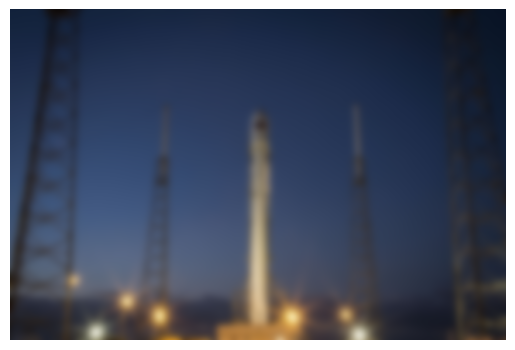

In [9]:
blurred = filters.gaussian(data.rocket(), channel_axis=2, sigma=5)
plt.imshow(blurred, cmap="gray")
plt.axis(False)


## Filters from scratch

In image processing a filter is an $N \times N$ matrix with values that are used as weights applied to the corresponding pixel and its neighboring pixels (dot product). The mean filter (matrix) has filter values of ones and calculates the average over a region specified by the filter size.  The size of the filter determines the extent of smoothing/blurring applied to the signal.  A larger filter will lead to more smoothing by averaging over a larger area. The function `mean_filter` in the cell below produces a mean filter:

In [11]:
def create_mean_filter(size):
    return np.ones((size, size, 1))/(size**2)

mean_filter =  create_mean_filter(10)

The cell below plots the mean filter:

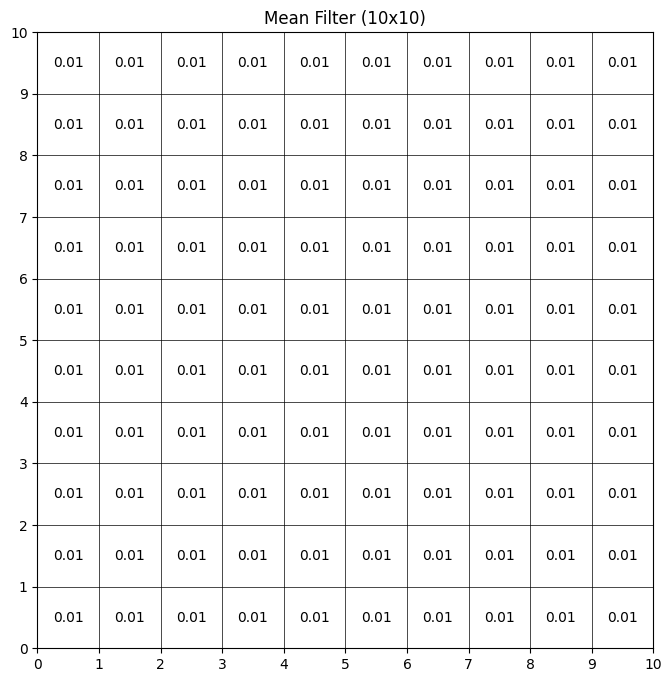

In [12]:
# Create a 10x10 grid to display the filter values
plt.figure(figsize=(8, 8))
plt.imshow(mean_filter[:, :, 0], cmap='gray', interpolation='none', vmin=0, vmax=0.01, extent=[0, 10, 0, 10])  # Adjust vmin and vmax for your specific filter values

# Display the values inside each cell
for i in range(mean_filter.shape[0]):
    for j in range(mean_filter.shape[1]):
        plt.text(j + 0.5, i + 0.5, f'{mean_filter[i, j, 0]:.2f}', color='black', ha='center', va='center')

plt.title('Mean Filter (10x10)')
plt.xticks(np.arange(0, 11, 1))
plt.yticks(np.arange(0, 11, 1))
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

When the filter is convolved with an image (applying the dot product iteratively on each color channel), each pixel in the output image represents the average of its surrounding pixels, producing a smoothed image. The cell below visualizes the image of the rocket ship. The pixel values have been normalized and downsampled to 20x20 pixels for display purposes: 

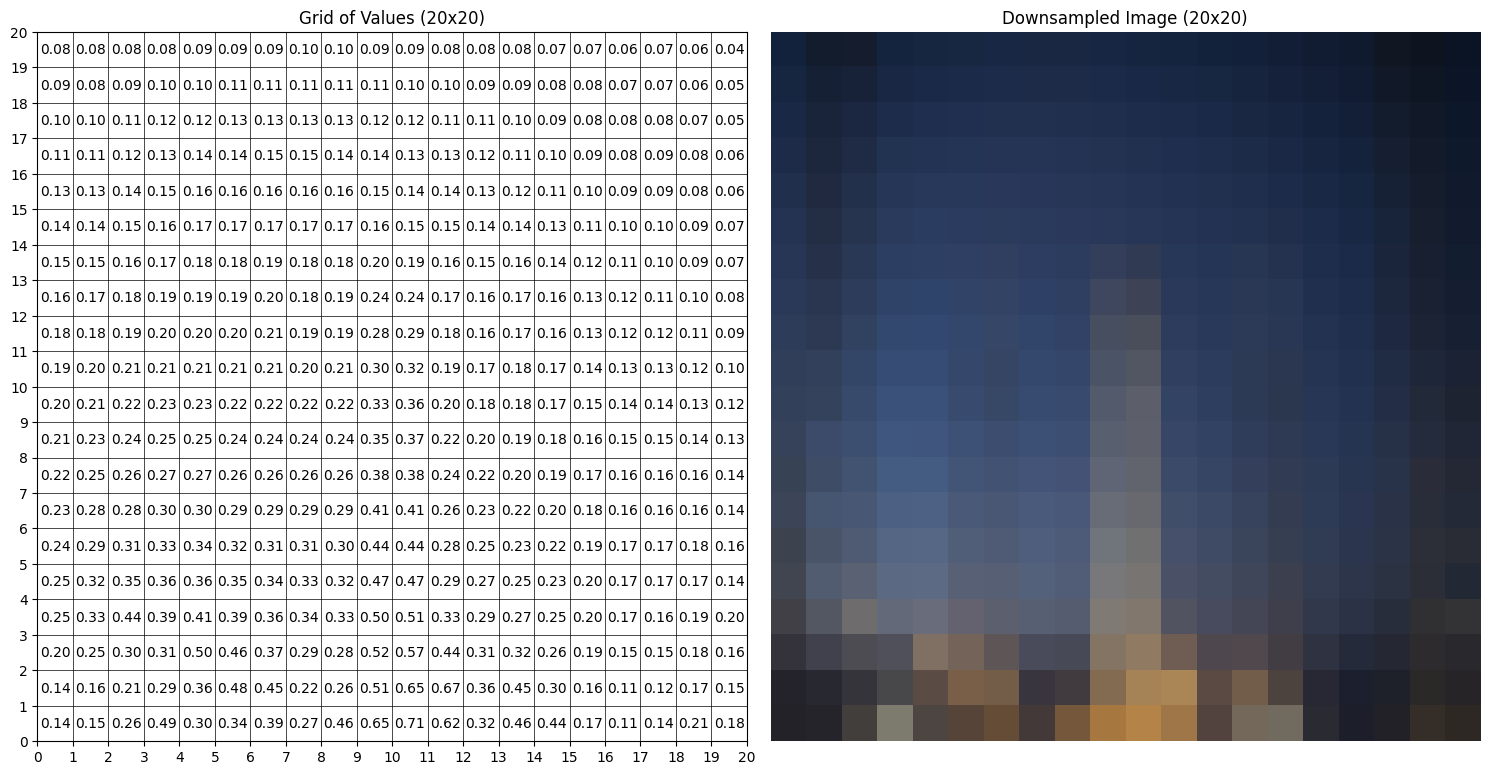

In [13]:
# Load the "camera" image from scikit-learn
data1 = data.rocket()
from skimage.transform import resize

# Resize the image to a smaller size
target_height, target_width = 20, 20  # Set your desired dimensions
resized_image = resize(data1, (target_height, target_width))

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot the grid of values in the first subplot
axes[0].imshow(np.ones_like(resized_image), cmap='gray', extent=[0, 20, 0, 20], vmin=0, vmax=1)  # Display white cells

# Display the values strictly inside each cell
for i in range(target_height):
    for j in range(target_width):
        pixel_value = resized_image[i, j, 0]
        axes[0].text(j + 0.5, target_height - i - 0.5, f'{pixel_value:.2f}', color='black', ha='center', va='center')

axes[0].set_title('Grid of Values (20x20)')
axes[0].set_xticks(np.arange(0, 21, 1))
axes[0].set_yticks(np.arange(0, 21, 1))
axes[0].grid(color='black', linestyle='-', linewidth=0.5)

# Plot the downsampled image in the second subplot without pixel values
axes[1].imshow(resized_image, cmap='hot', vmin=0, vmax=1)
axes[1].set_title('Downsampled Image (20x20)')
axes[1].axis('off')  # Hide axis for the image plot

plt.tight_layout()
plt.show()

The cell below convolves the mean filter to the rocket image  using  `scipy.ndimage.convolve`:

(-0.5, 639.5, 426.5, -0.5)

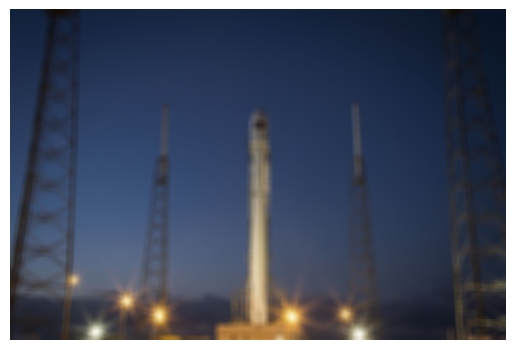

In [14]:
blurred = scipy.ndimage.convolve(data.rocket(), mean_filter)
plt.imshow(blurred)
plt.axis(False)

### Edge Filter by convolution

Edges are places in the images with large differences between intensity/color values and correspond to intensity gradients. By constructing a filter that calculates the partial derivatives of an image in either the $x$ or $y$ direction linear filters can be used to find edges in an image in a certain direction.

The definition of the partial derivative of a function $f$ with respect to $x$ is defined as:

$$
\begin{align}
\frac{\partial f(x, y)}{\partial x} = \lim_{\Delta \rightarrow 0} \frac{f(x+\Delta, y) - f(x,y)}{\Delta}
\end{align}
$$

An image is a discrete approximation of the light distribution hitting the camera sensor with integer indices. The partial derivative can be approximated by setting $\Delta$ to $1$ (smallest possible step). This method is known as the *finite differences* method:

$$
\begin{align}
\frac{\partial f(x, y)}{\partial x} \approx  \frac{f(x+1, y) - f(x,y)}{1} = f(x+1, y) - f(x, y)
\end{align}
$$

This expression is the difference between neighboring pixels. The corresponding filter to calculate the derivative with respect to $x$ is:

$$
k_{x} = \begin{bmatrix}1&-1\end{bmatrix}
$$

Equivalently, the filter for calculating the derivative in the $y$-direction is:

$$
\begin{align*}
k_{y} &= \begin{bmatrix}1 \\ -1\end{bmatrix}
\end{align*}
$$


You may have noticed that the $1$ and $-1$ seem reversed in the filter. This is due the definition of convolution. The cell below implements the filter and convolves it with the image . The image is grayscale but displayed using brown colors for illustrative purposes:

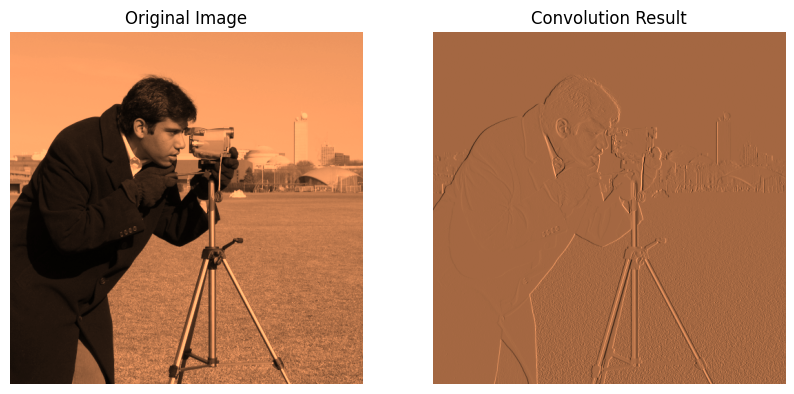

In [15]:
k_x = np.array([[1, -1]])

image = data.camera().astype(np.float32)

dx = convolve(image, k_x)

# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image in the first subplot
axs[0].imshow(data.camera(), cmap='copper')
axs[0].set_title('Original Image')
axs[0].axis('off')

# Plot the result of convolution in the second subplot
axs[1].imshow(dx, cmap='copper')
axs[1].set_title('Convolution Result')
axs[1].axis('off')

# Display the subplots
plt.show()

In practice, the finite differences method is not robust to noise. A larger filter e.g. $k_{x} = \begin{bmatrix}1&0&-1\end{bmatrix}$ may remedy this. This is because the previous filter calculates the approximate derivative between two pixels, whereas the modified filter calculates it at the exact pixel location.

Additionally, the image is typically blurred (or smoothed) using a Gaussian filter before calculating the derivative, to decrease the effect of noise and other very small features. The Gaussian filter blurs the image by convolving the image with a Gaussian filter defined by the scale parameter (`sigma`). Increasing sigma leads to more blurring, because the filter becomes larger:

(-0.5, 511.5, 511.5, -0.5)

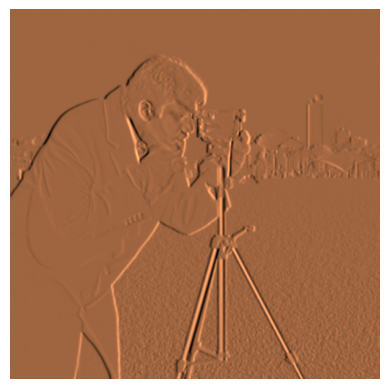

In [29]:
k_x = np.array([[1, 0, -1]]) # The new centered filter

image_blurred = filters.gaussian(image, sigma=1) # Blurring with a Gaussian, larger sigma more blurring

dx = convolve(image_blurred, k_x)
plt.imshow(dx, cmap='copper')
plt.axis(False)

Due to the associative property of convolution, it is possible to convolve the gaussian and derivative filters to produce a filter that performs both operations (differentiation and blurring). Performing a convolution operation between the derivative filter and the Gaussian filter is the same as to taking the derivative of the Gaussian, resulting in the creation of a new filter. In the cell below a derivative filter (`k_x`) is created then convolved with a Gaussian. The combined filter is then applied to the image. Notice that this is a linear operation.

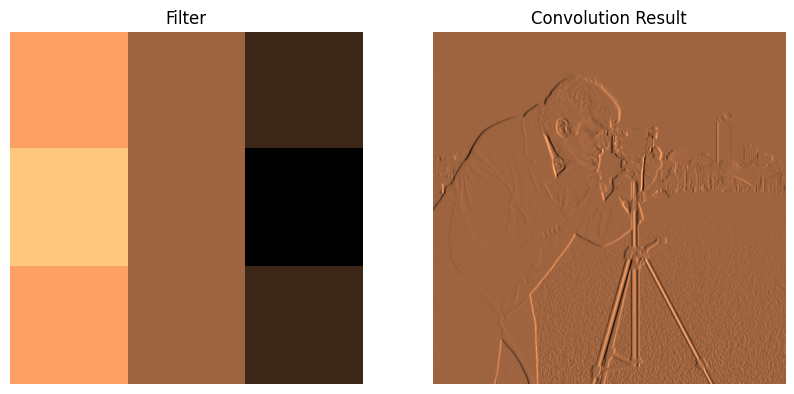

In [16]:
# The filter has to be padded with zeroes, otherwise the convolution will result in a new 1x3 filter 
# (try it yourself if you want to see the result)
k_x = np.array([
    [0, 0, 0],
    [1., 0, -1.],
    [0, 0, 0]
]) 

# we apply the blurring to the filter instead of the image
k_x_blurred = filters.gaussian(k_x, sigma=1, preserve_range=True) 
dx = convolve(image, k_x_blurred) # convolve the image with the blurred filter

# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image in the first subplot
axs[0].imshow(k_x_blurred, cmap='copper')
axs[0].set_title('Filter')
axs[0].axis('off')

# Plot the result of convolution in the second subplot
axs[1].imshow(dx, cmap='copper')
axs[1].set_title('Convolution Result')
axs[1].axis('off')

# Display the subplots
plt.show()


There are several filters for edge detection. One such filter is the *sobel filter* which is included in scikit-image. The sobel filter is used to highlight large changes within an image by convolving the image with two 3x3 filters (one for detecting changes in the horizontal direction and the other for the vertical direction). The result of applying it on the $x$-direction is shown below:

(-0.5, 511.5, 511.5, -0.5)

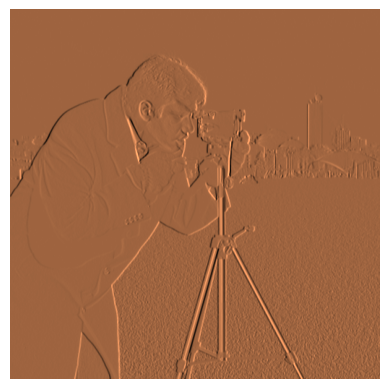

In [35]:
dx = filters.sobel(image, axis=1)
plt.imshow(dx, cmap='copper')
plt.axis(False)

The cell below defines a derivative filter for finding derivatives in the $y$-direction. The filter is convolved with a Gaussian filter, before it is applied to the image:  


(-0.5, 511.5, 511.5, -0.5)

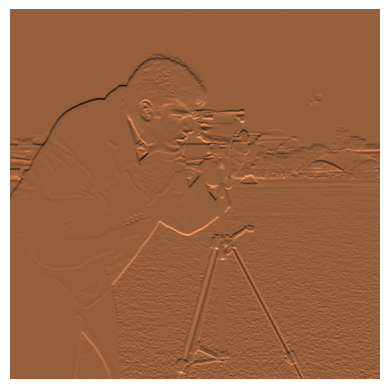

In [17]:
k_y = np.array([
    [0, 1., 0],
    [0, 0, 0],
    [0, -1., 0]
])

k_y_blurred = filters.gaussian(k_y, sigma=1, preserve_range=True) # we apply the blurring to the filter instead of the image
dy = convolve(image, k_y_blurred) # convolve the image with the blurred filter
plt.show()
plt.imshow(dy, cmap='copper')
plt.axis(False)


By applying the horizontal and vertical edge detection filters, areas in the image where pixel intensities change rapidly were highlighted, indicating potential edges. Remember that these filters were convolved with a Gaussian filter for noise reduction. 

In the cell below, the gradient magnitude (`gradMag`, the length of the gradient) is calculated. The values indicate intensity changes in the image regions, making it easier to identify edges and key features in the image: 

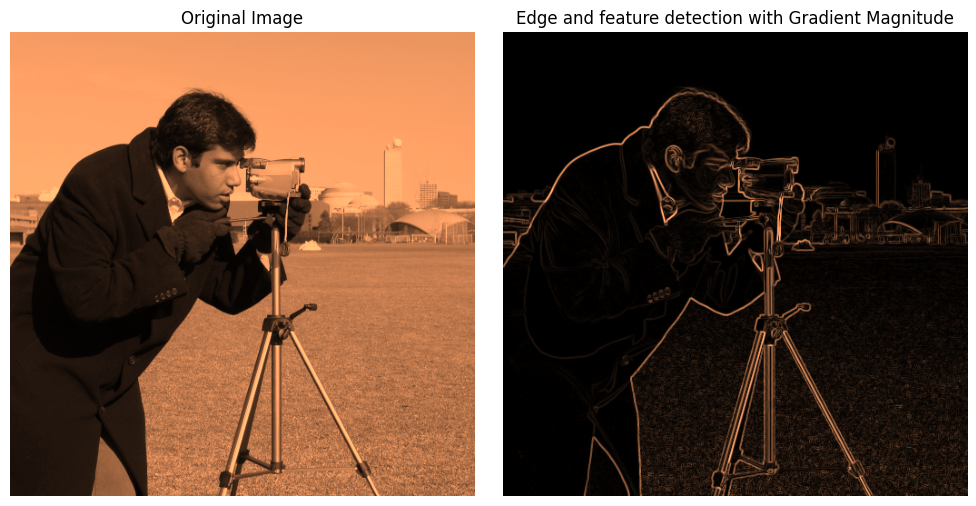

In [18]:
# Perform convolution to compute horizontal and vertical gradients
Ix = convolve(image, k_x_blurred)
Iy = convolve(image, k_y_blurred)

# Calculate gradient magnitude
gradMag = np.sqrt(Ix**2 + Iy**2)

# Create subplots to display the original image and gradient magnitude
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image, cmap='copper')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(gradMag, cmap='copper')
axes[1].set_title('Edge and feature detection with Gradient Magnitude')
axes[1].axis('off')

plt.tight_layout()
plt.show()